# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

/Users/zakscholl/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

In [4]:
responses = df_transactions.groupby(['customer_name', 
                                     'offer_id']).n.sum().unstack('offer_id').fillna(0)
responses.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

## What values of SS are better clusterings?

The sum of the squared error for a single cluster is better when it is lower. Though this is a relative measure and not an absolute one. If you were to assign each point its own cluster in the dataset, then you would achieve a zero sum of squared error, but this is not a good clustering assignment.

If a single cluster has a lower SS, that means the points are closer to the 'centroid' or center of the cluster, meaning the cluster is more dense. 

In practice, however, finding the right amount, and position, of clusters is much more complicated than picking the clustering with the lowest SS.

In [5]:
x_cols = responses.values

In [6]:
from sklearn.cluster import KMeans

def apply_cluster(data, k=8):
    """
    Applies kmeans clustering for k, and returns the fitted classifer and the sum
    of the squared error for that classifier.
    """
    clf = KMeans(n_clusters=k)
    clf.fit(data)
    return (clf, ss_error(data, clf))

def ss_error(data, clf):
    """
    Returns the sum of the squared error for a kmeans classifier.
    """
    clusters = clf.transform(data)
    return np.sum(np.min(clusters, axis=1) ** 2)


ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
errs = [apply_cluster(x_cols, k)[1] for k in ks]

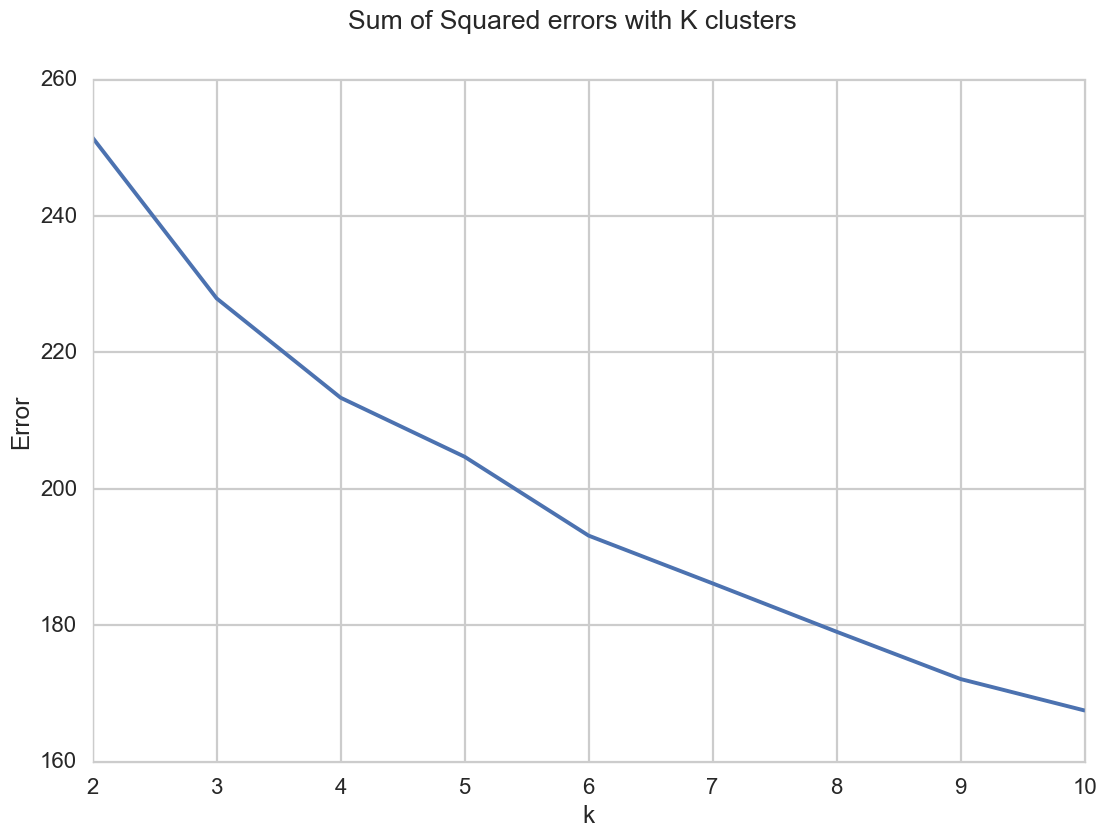

In [7]:
fig = plt.figure()
plt.plot(ks, errs)
fig.suptitle('Sum of Squared errors with K clusters')
plt.xlabel('k')
plt.ylabel('Error')
None

Based on the elbow at 9, I think 9 is a good value for K.

In [8]:
clf = apply_cluster(x_cols, k=9)[0]
clusters = clf.predict(x_cols)

In [9]:
hist = np.histogram(clusters, bins=9)[0]

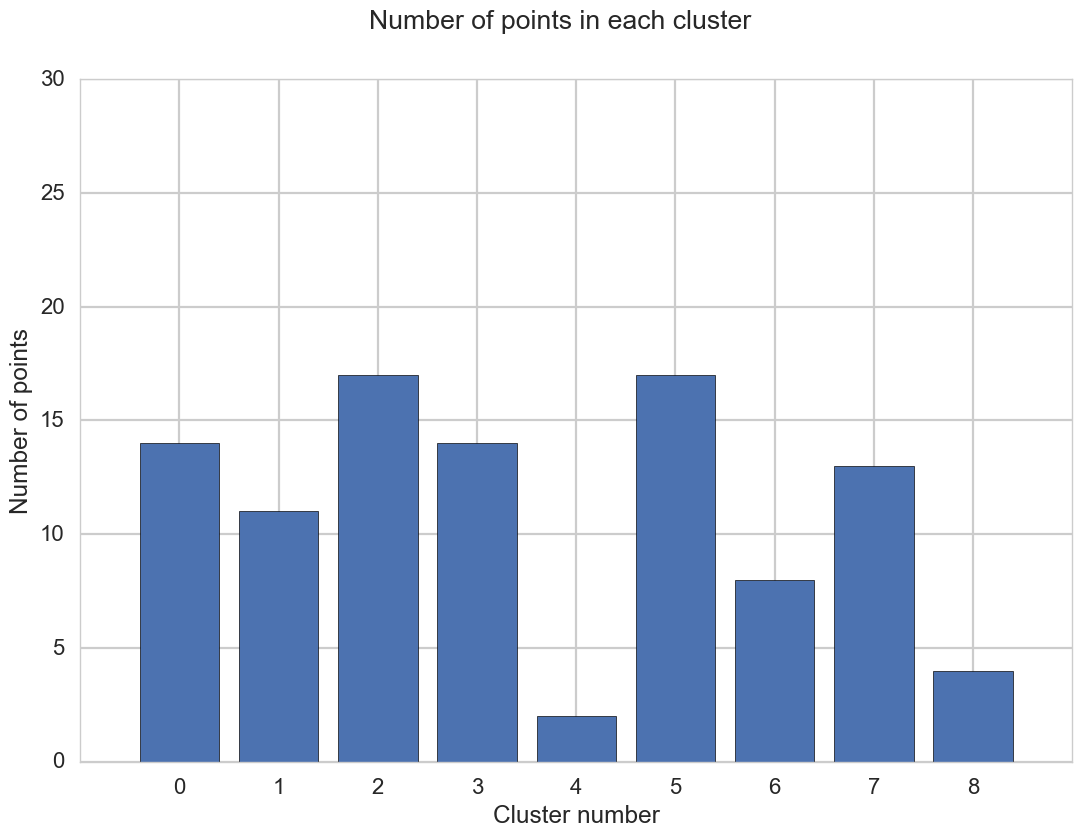

In [10]:
fig = plt.figure()
plt.bar(np.arange(9), hist, tick_label=np.arange(9), align='center')
fig.suptitle('Number of points in each cluster')
plt.ylim((0,30))
plt.xlabel('Cluster number')
plt.ylabel('Number of points')
None

## Challenges

Using the elbow method is not as clear cut as it has been demonstrated to me in the past. I was expecting to see an elbow immediately in the first few values of k, but in this example there wasn't a clear elbow until the end, at k=9.

Despite this, it's not a difficult method to use to evaluate k.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

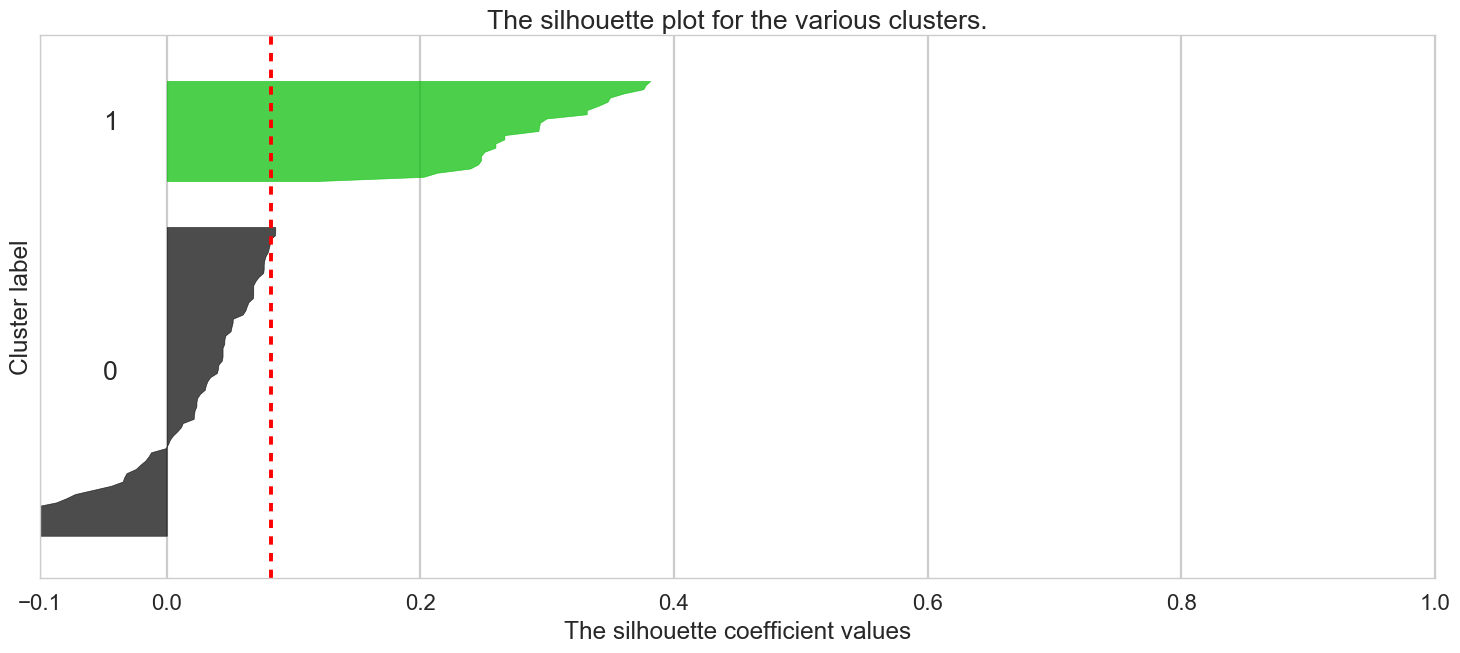

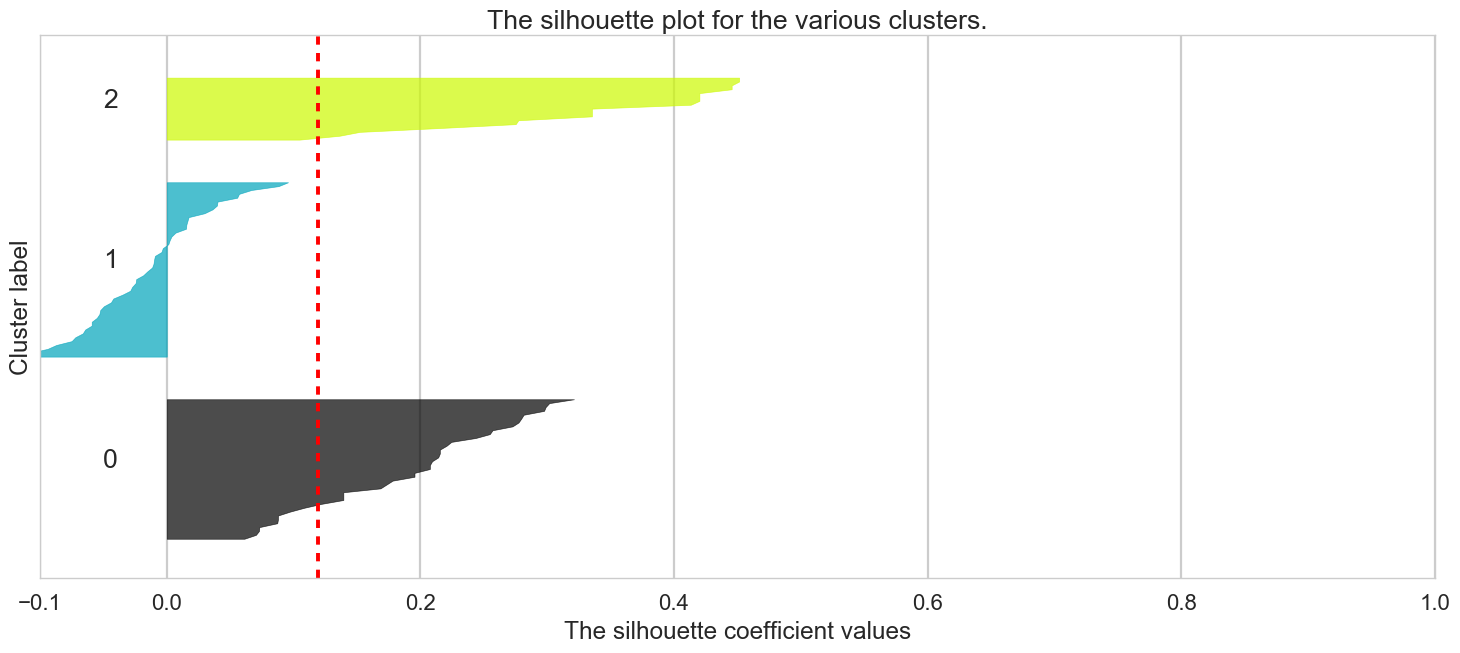

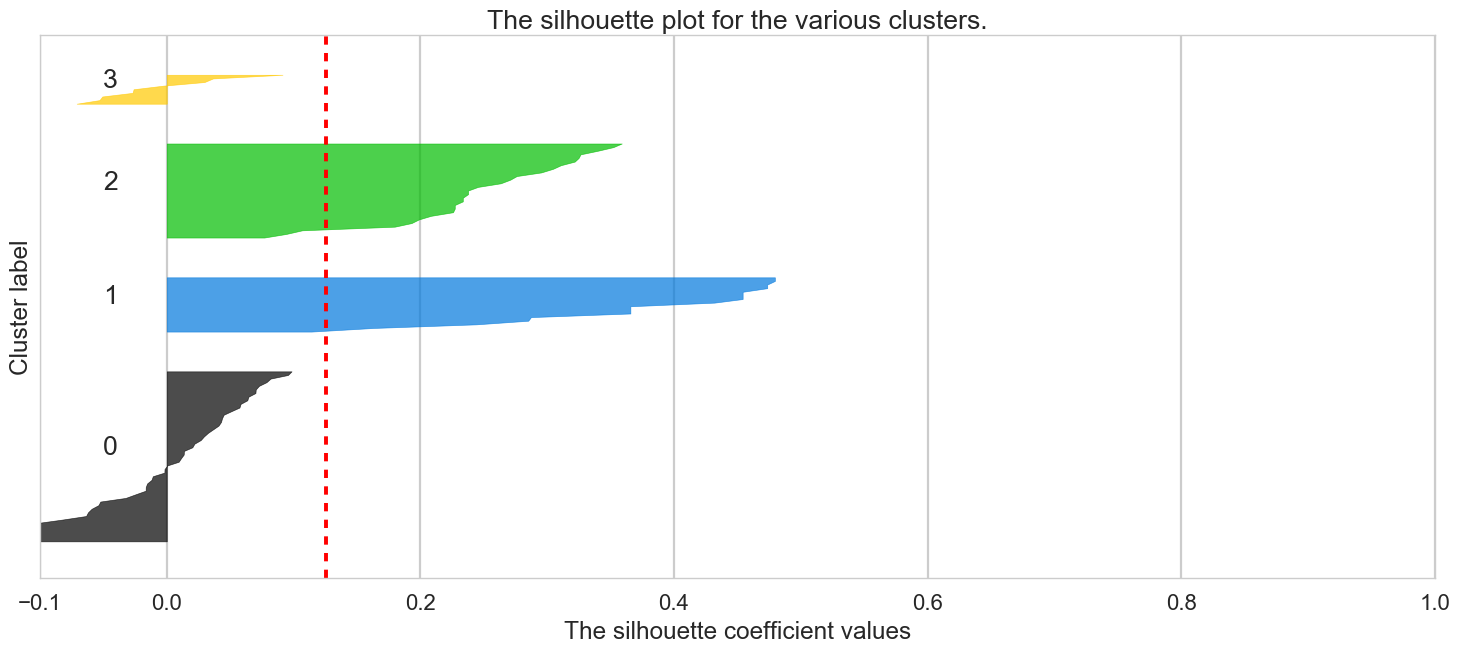

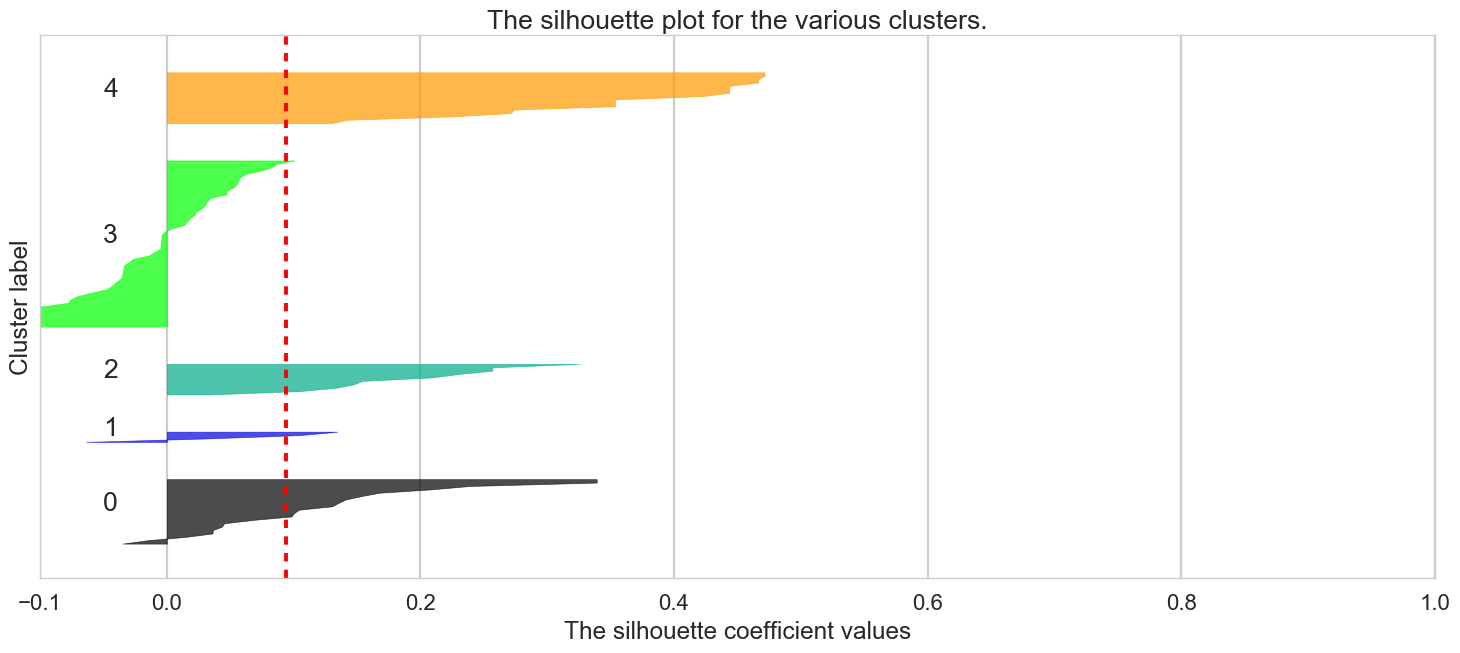

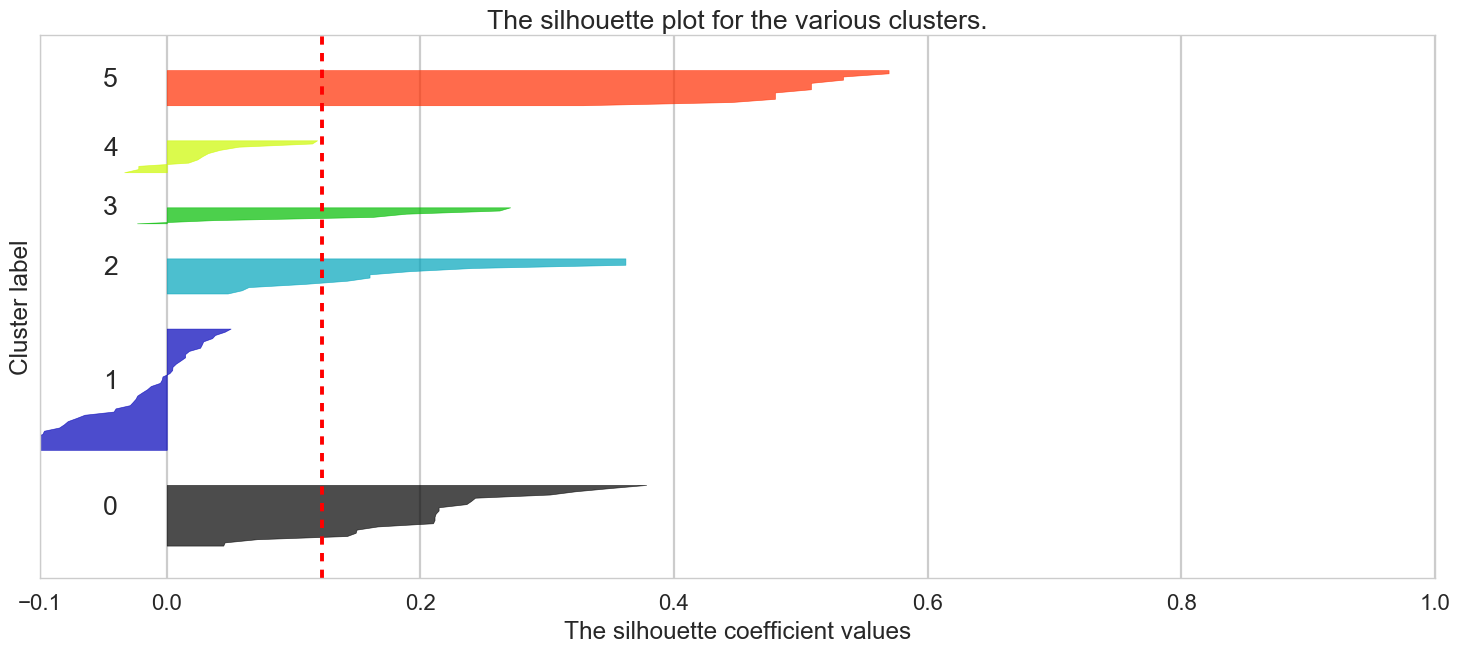

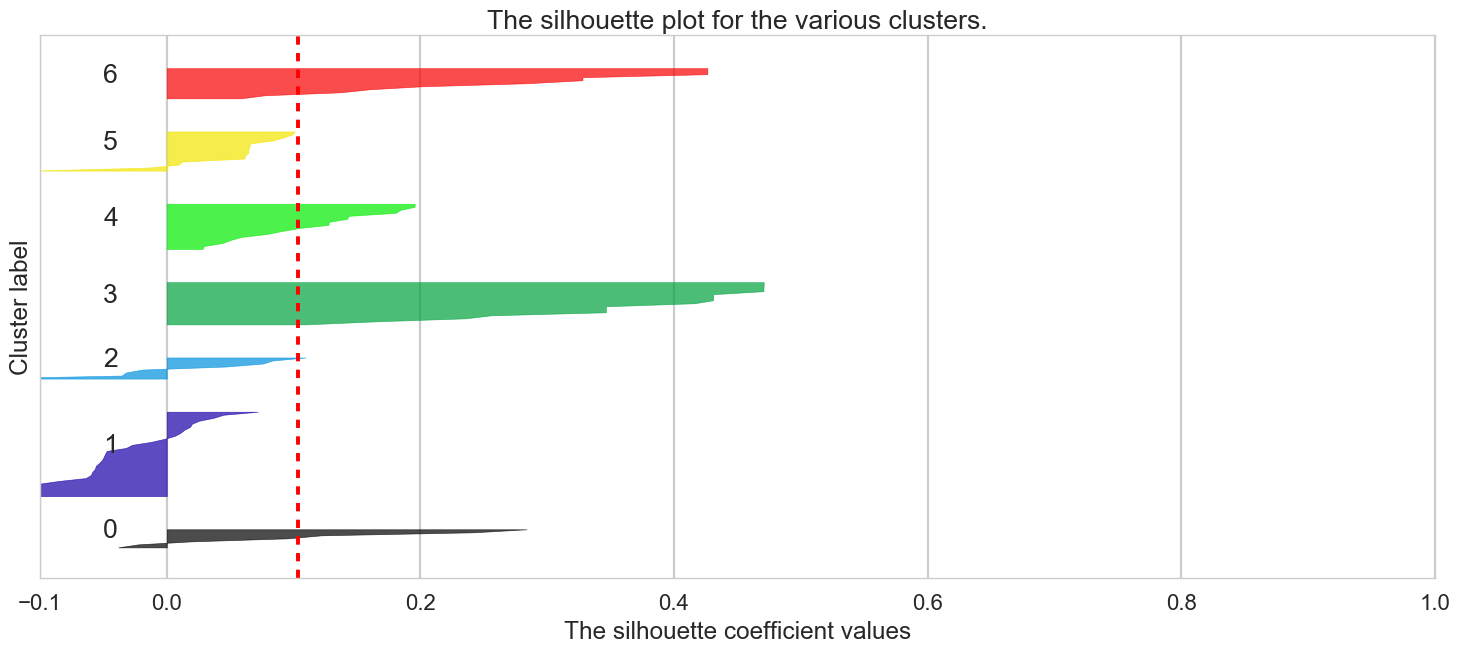

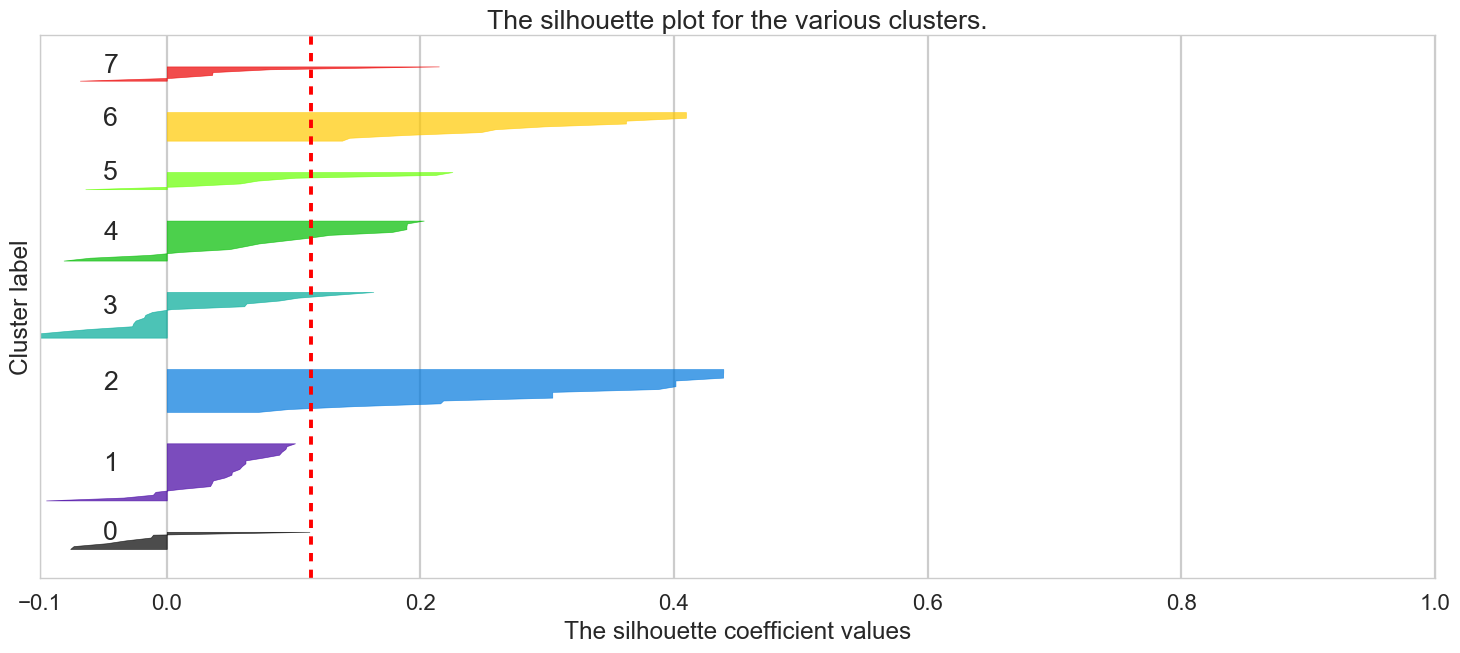

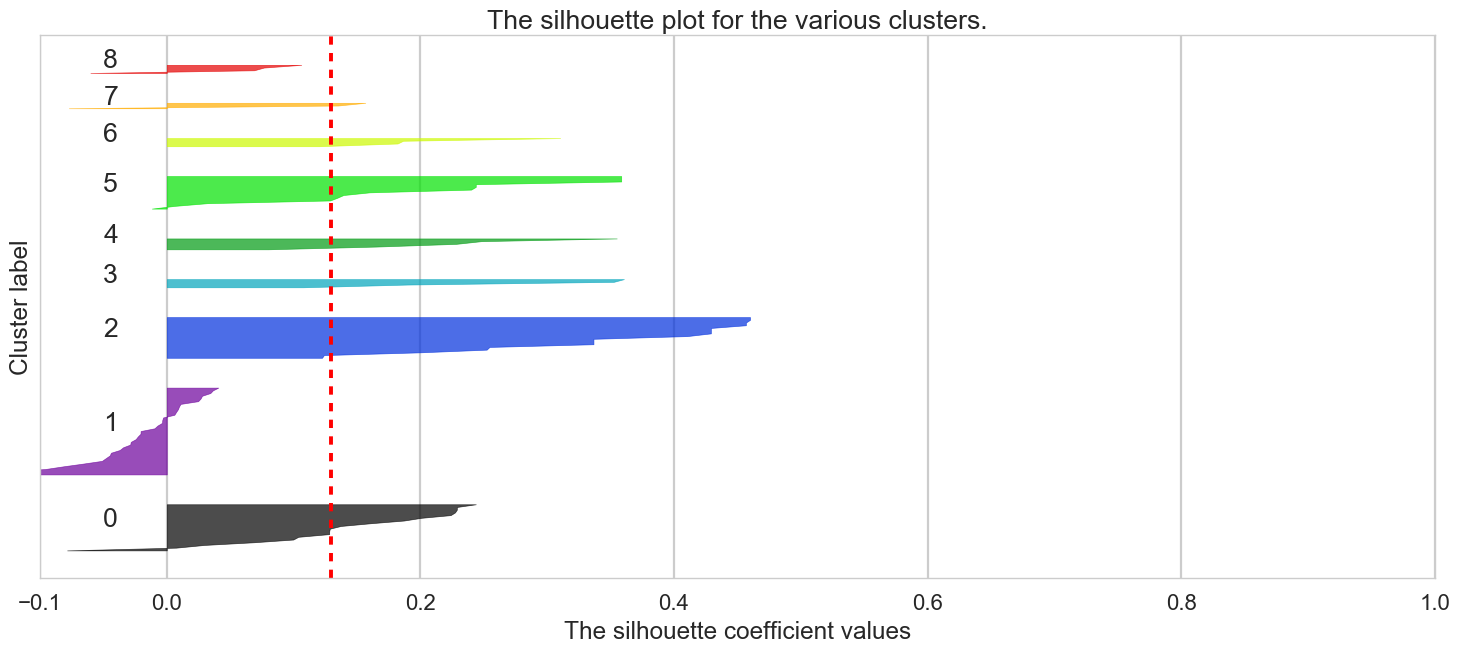

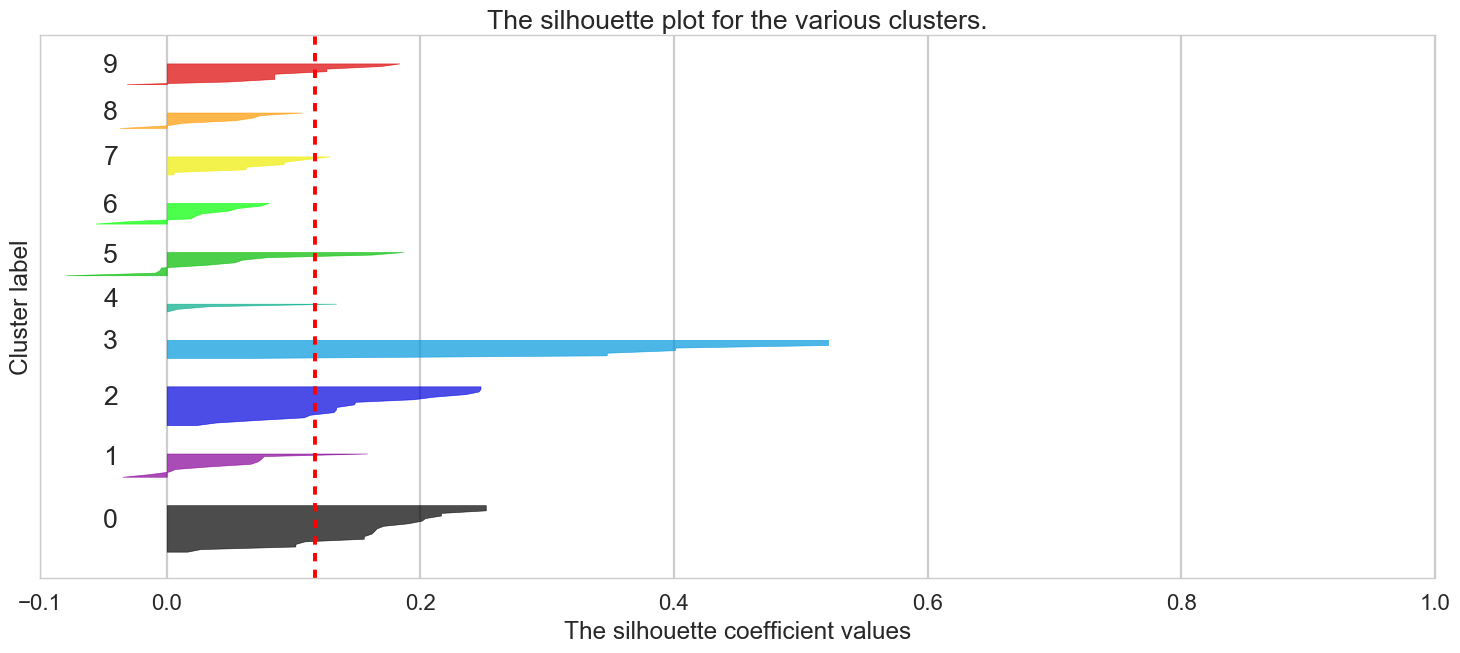

In [11]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

silhouette_avgs = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## Silhouette summary

So the silhouette scores are a little less satisfying than I was hoping. None of the chosen values for K produced an average score over 0.25. 

However, it's not a lost cause. At K=4 the best average silhouette score was achieved, at 0.13. But that's largely because of an outlier of cluster 3. 

Every value of k produces some clusters that have negative silhouette scores for some points. Despite this, I still like k=9. Because 6 of the 9 clusters reach over 0.25 for most of the points. The other three clusters have pretty poor silhouettes, but I'll take 6, pretty good, clusters.

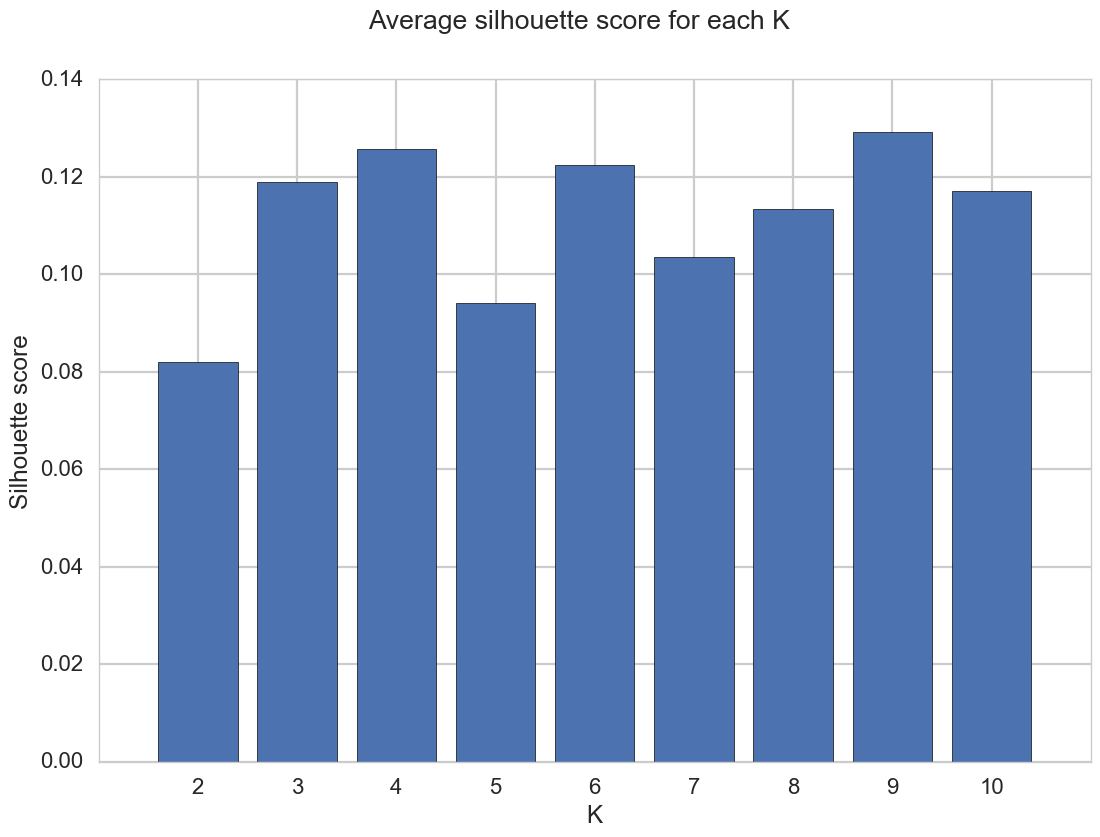

In [12]:
fig = plt.figure()
plt.bar(ks, silhouette_avgs, tick_label=ks, align='center')
fig.suptitle('Average silhouette score for each K')
# plt.ylim((0,30))
plt.xlabel('K')
plt.ylabel('Silhouette score')
None

This plot suggests we should use k=4. But even though it has the best average silhouette score, I still like k=9 better because of how all of the silhouettes look.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

In [13]:
from sklearn.decomposition import PCA
clf = PCA(n_components=2)

fitted = clf.fit_transform(x_cols)

In [14]:
import matplotlib.patches as mpatches

def graph_cluster(k):
    clf = apply_cluster(x_cols, k=k)[0]
    clusters = clf.predict(x_cols)
    
    df = pd.DataFrame(fitted)
    df.columns = ['x', 'y']
    df.index = responses.index
    df['cluster'] = clusters
    choices = sns.color_palette("Set1", n_colors=k)
    df['color'] = df.cluster.apply(lambda x: choices[x])
    
    sns.regplot(x='x', y='y', fit_reg=False, data=df, scatter_kws={'color': np.array(df.color.tolist()), 's': 75})
    recs = []
    for i in range(0,len(choices)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=choices[i]))
    plt.legend(recs, np.arange(k), loc=1)
    
    fig = plt.gcf()
    fig.suptitle('Scatter plot for K={}'.format(k))

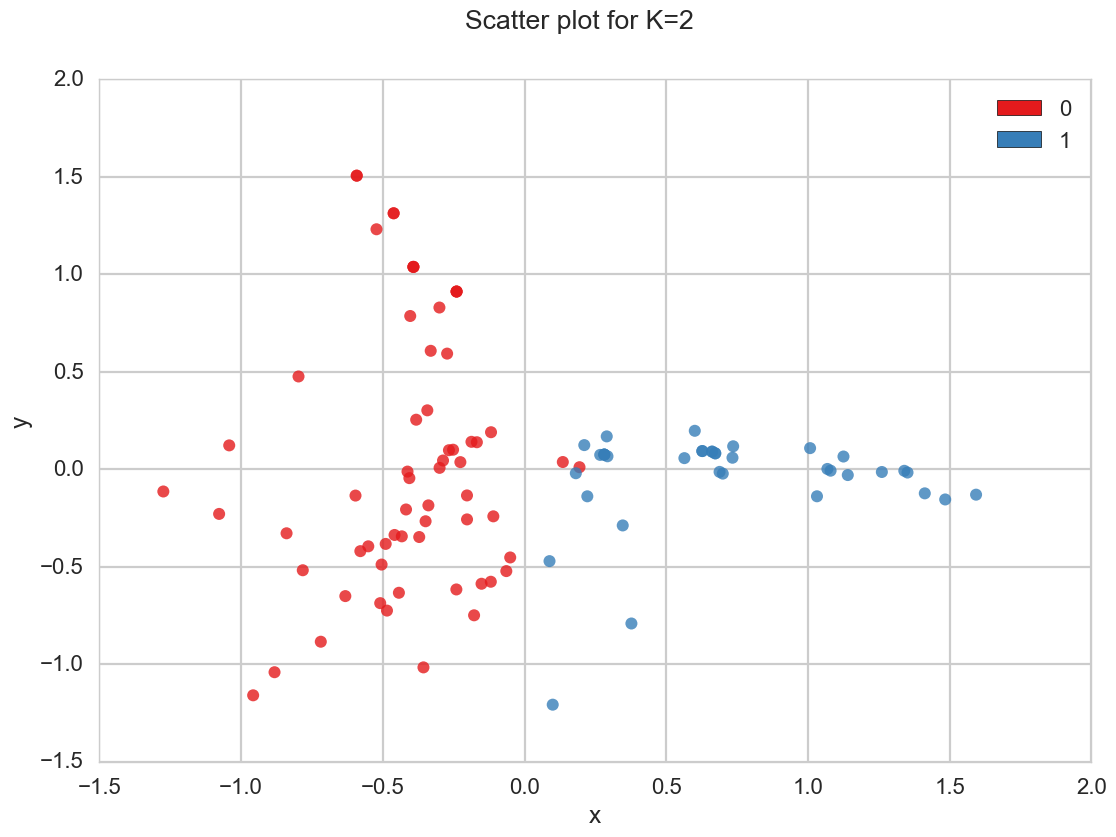

In [15]:
graph_cluster(2)

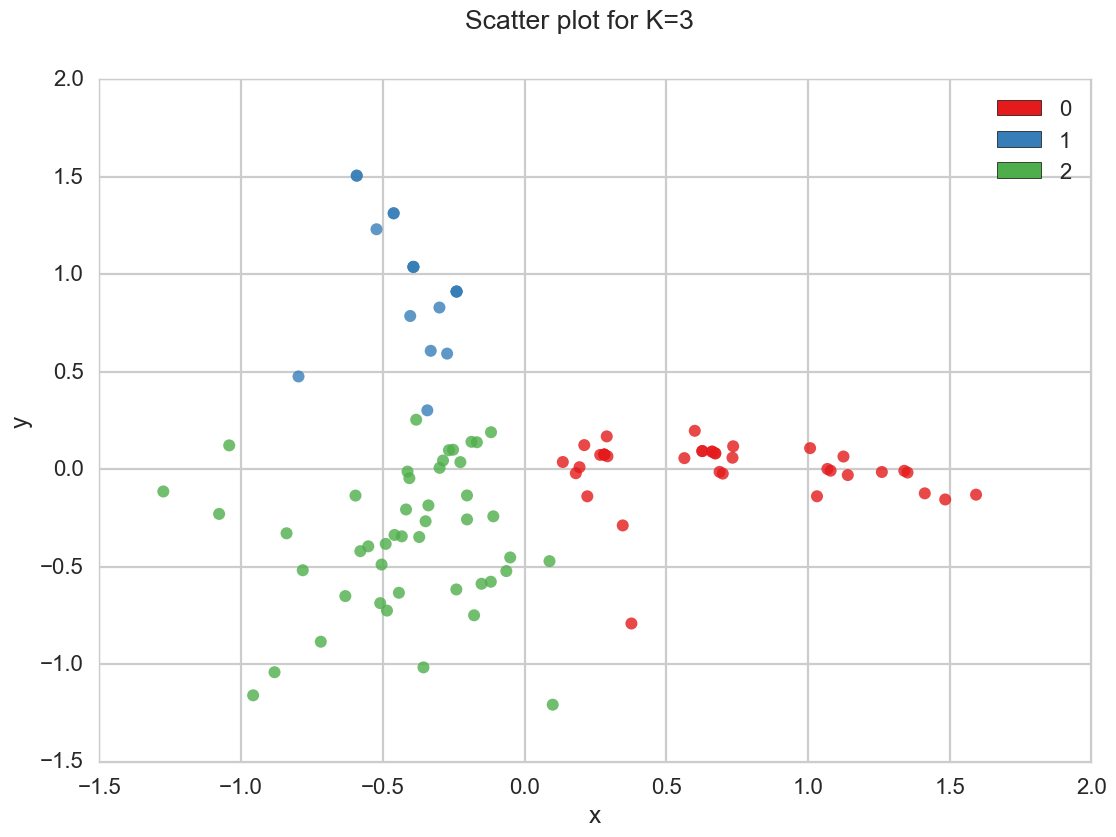

In [16]:
graph_cluster(3)

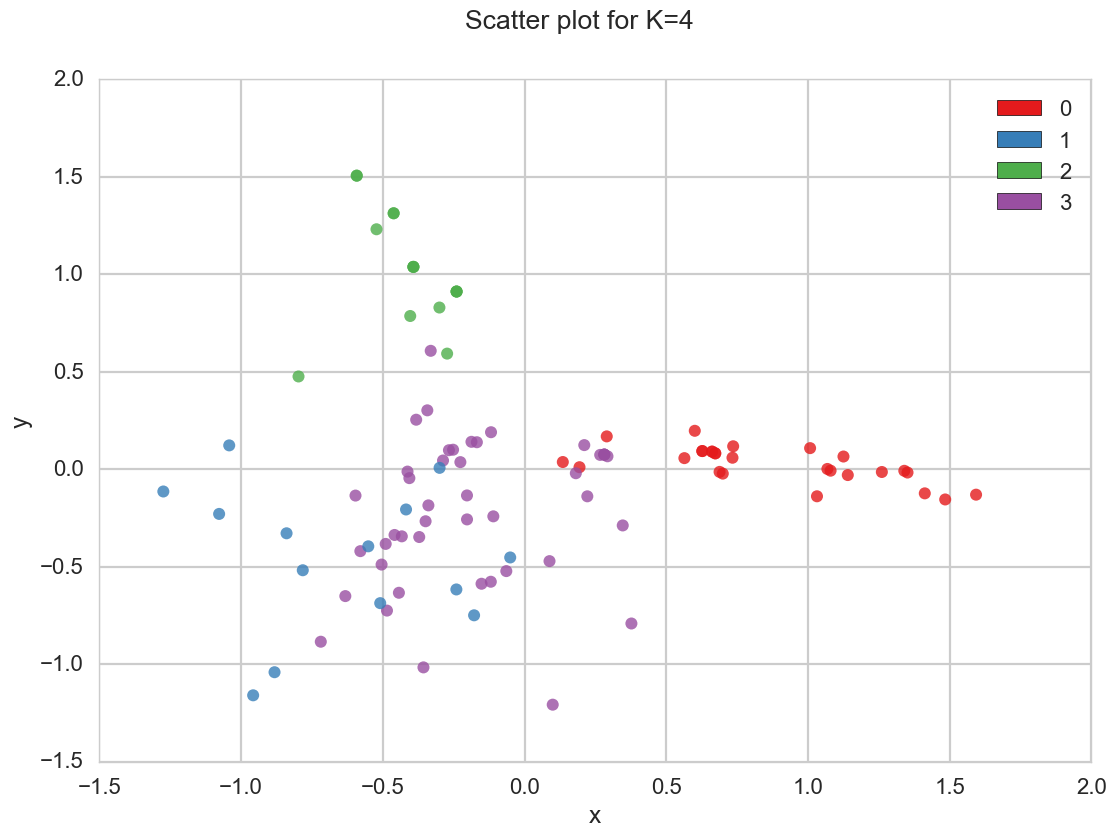

In [17]:
graph_cluster(4)

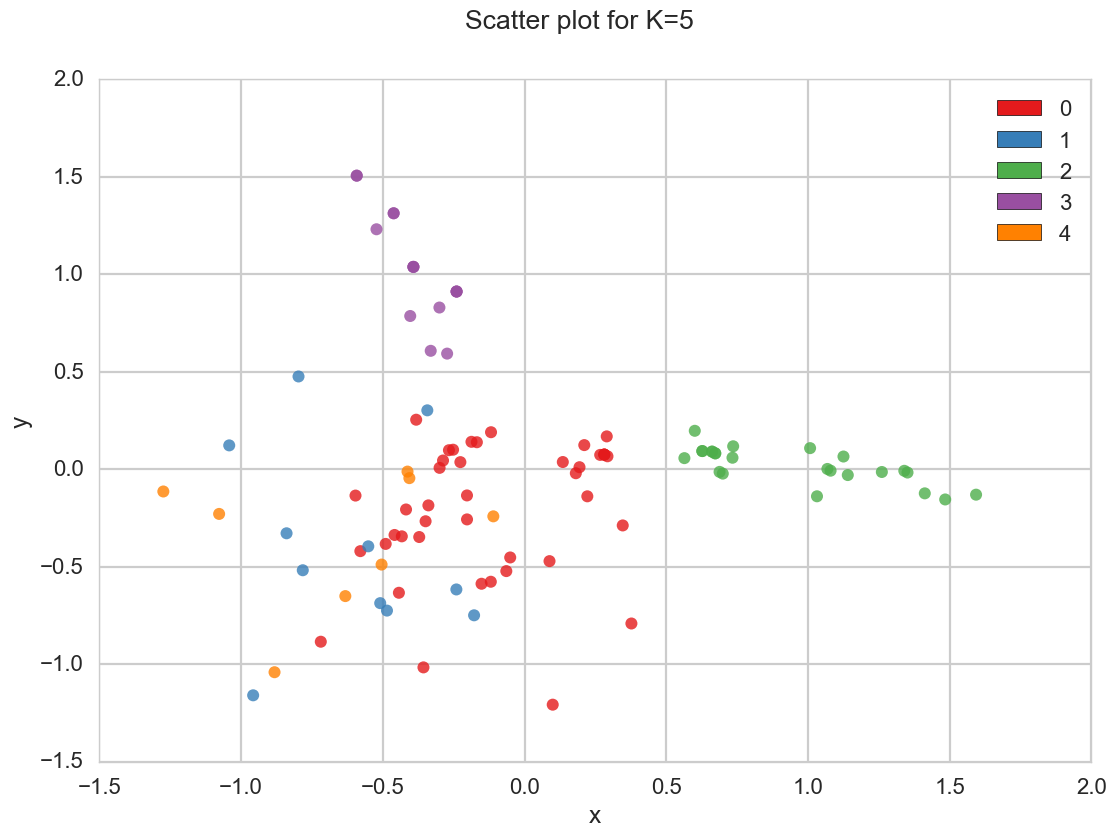

In [18]:
graph_cluster(5)

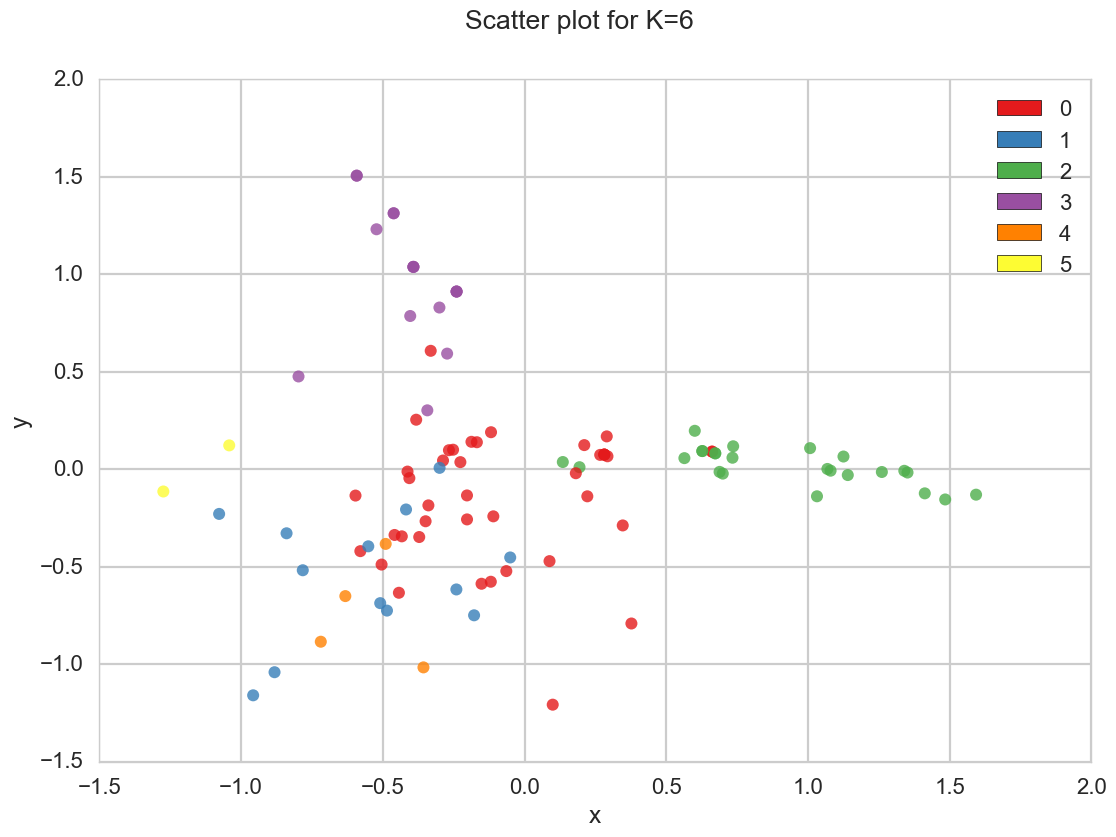

In [19]:
graph_cluster(6)

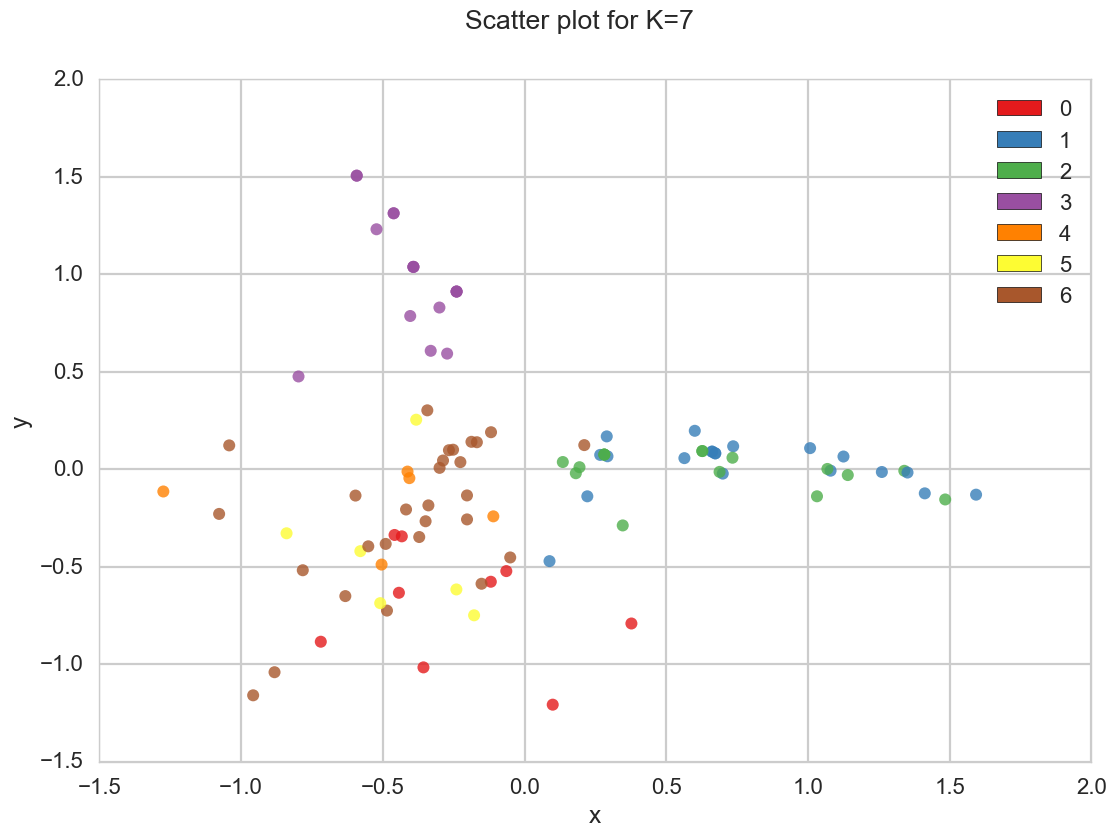

In [20]:
graph_cluster(7)

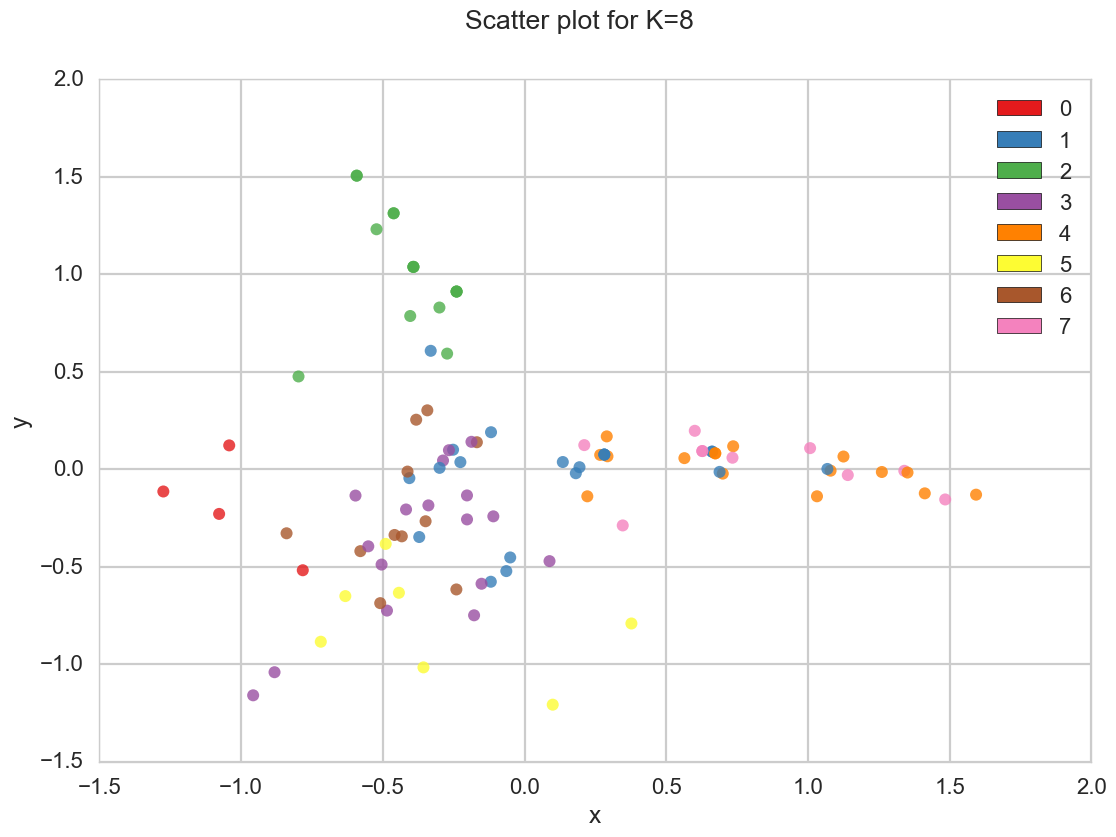

In [21]:
graph_cluster(8)

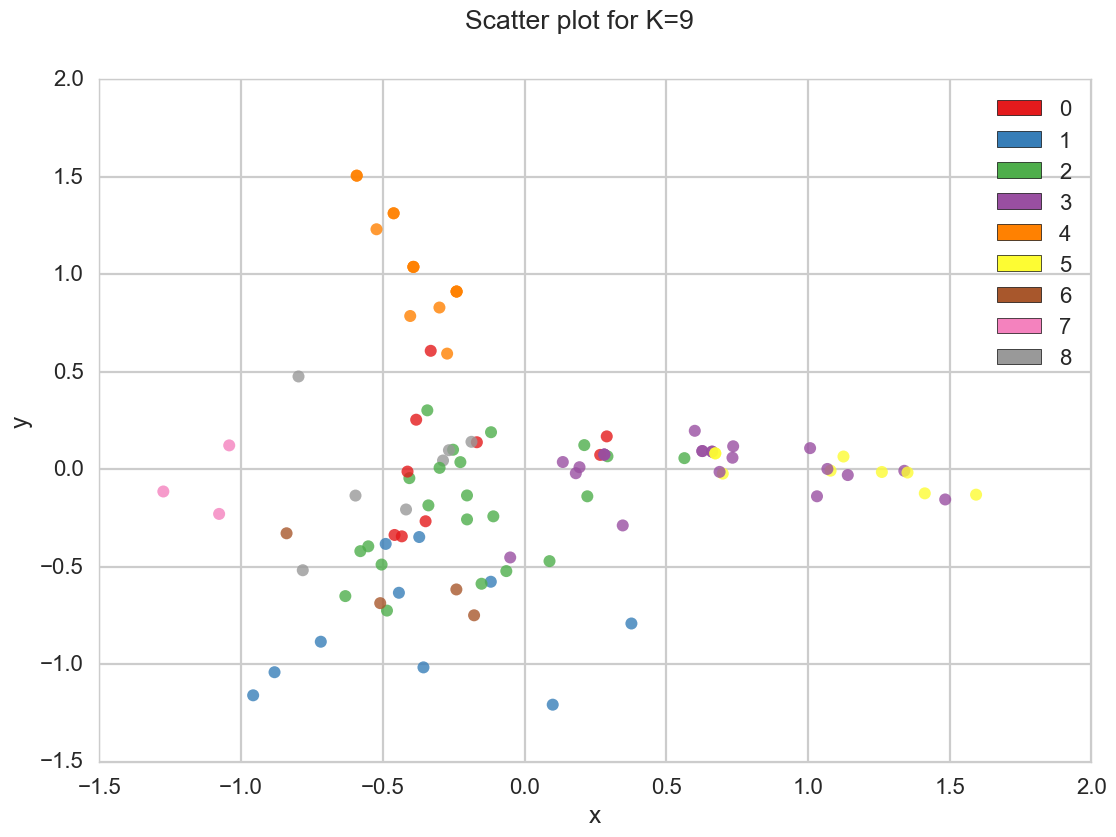

In [22]:
graph_cluster(9)

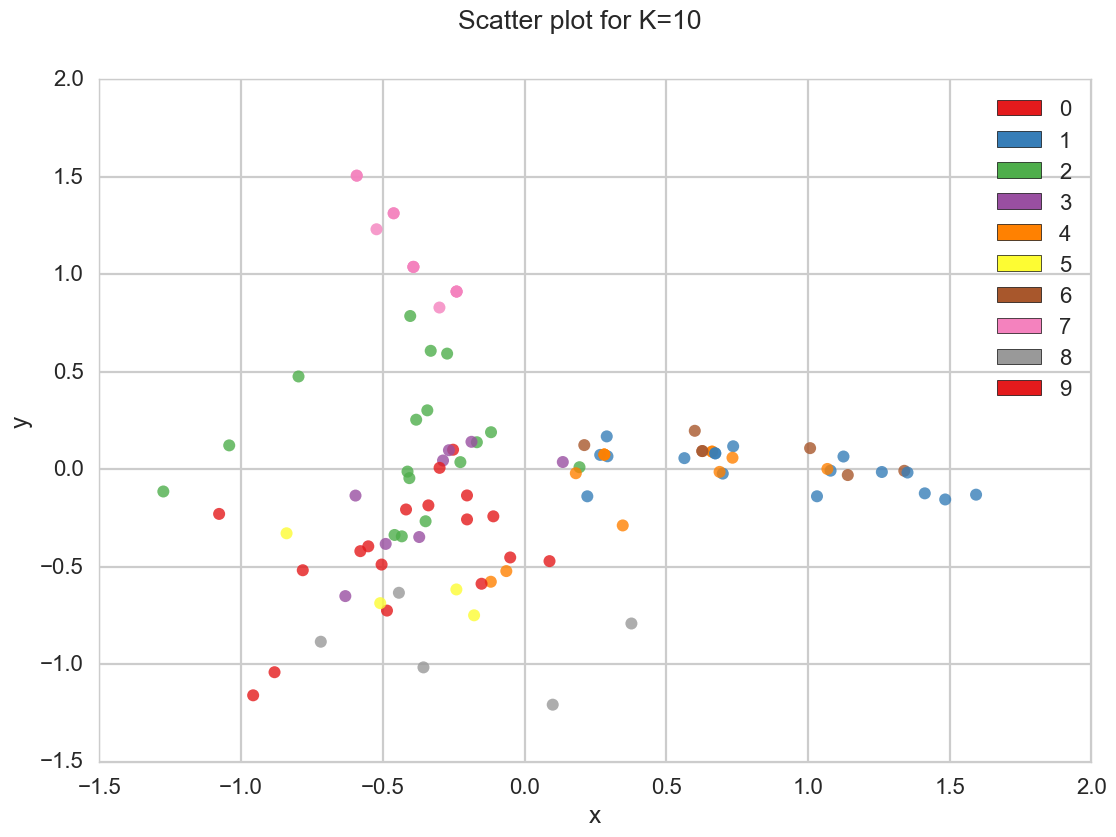

In [23]:
graph_cluster(10)

The best visual clusterings are when k is equal to 3, 4, and 5. The k equals 3 cluster is the most visually appealing because there is no overlap among the clusters. Visually, they fit very nicely into their groups.

This visual representation makes a stronger case for k=5. Visually the clustering looks to make a lot more sense than k=9. Considering that was the k that produced the best average silhouette score, it's making me reconsider my selection.

## Looking back at the data

In [24]:
responses['cluster'] = clusters
responses.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,cluster
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [25]:
df = responses.groupby('cluster').sum()
cm = sns.light_palette("green", as_cmap=True)


df.style.background_gradient(cmap=cm, low=0, high=0.3)

In [26]:
df_offers

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
5,6,March,Prosecco,144,86,Chile,False
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
8,9,April,Chardonnay,144,57,Chile,False
9,10,April,Prosecco,72,52,California,False


Cluster number 6 has exclusively bought Pinot Noir whenever it's on sale!

Cluster number 2 has bought whenever the minimum quantity is at 6, so those customers can be targeted with low minimum quantity orders.

Cluster number 8 has tended to by Chardonnays when they are on sale.

The other clusters don't seem to exhibit an obvious trend by any of the values in the offers table.


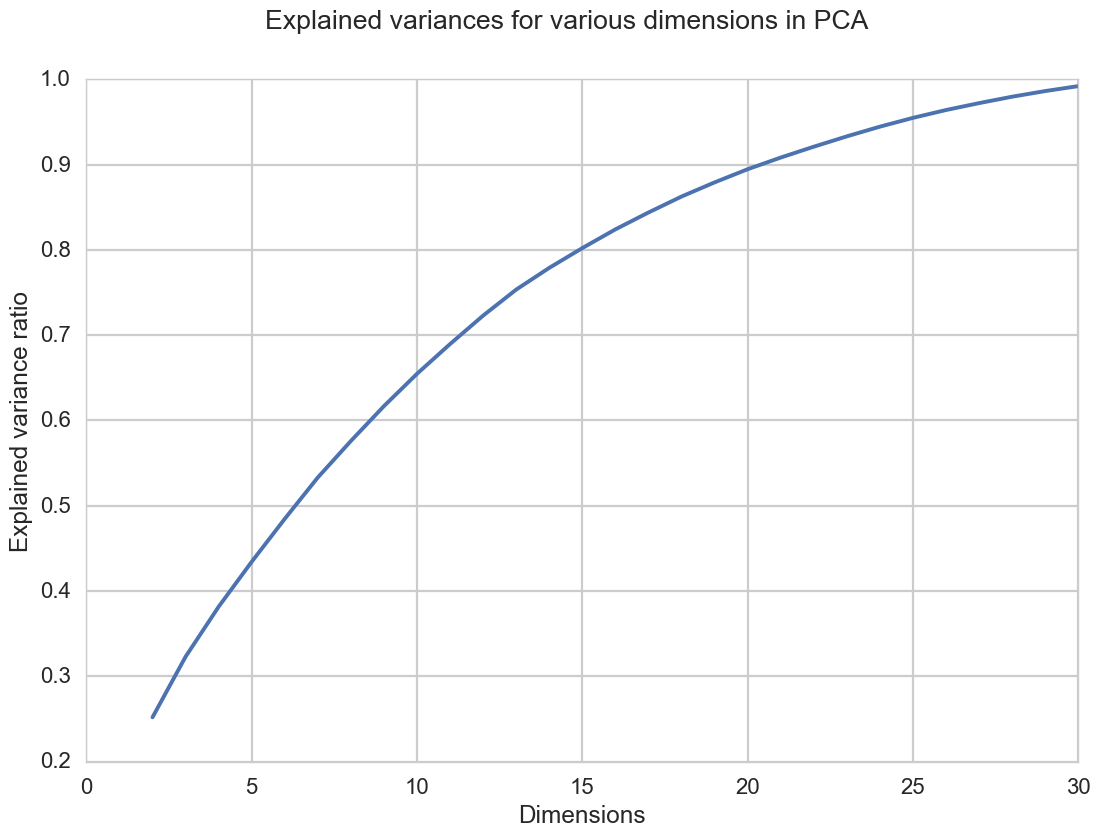

In [27]:
# Initialize a new PCA model with a default number of components.
from sklearn.decomposition import PCA
pca = PCA()

# Do the rest on your own :)
dims = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

variances = [ PCA(n_components=dim).fit(x_cols).explained_variance_ratio_.sum() for dim in dims]

fig = plt.figure()
plt.plot(dims, variances)
fig.suptitle('Explained variances for various dimensions in PCA')
plt.xlabel('Dimensions')
plt.ylabel('Explained variance ratio')
None

# Optimal number of dimensions

The explained variance curve does not have an obvious kink, it's pretty smooth throughout but it starts to level off between 10 and 15 dimensions. 

So I would choose 15 as the number of components to reduce down to.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

In [56]:
def graph_silhouette(clf, n_clusters):
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = clf
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("Average silhouette score is {}".format(silhouette_avg))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for {}".format(str(clf.__class__).split(".")[-1][:-2]))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Affinity Propagation

In [46]:
from sklearn.cluster import AffinityPropagation
afp = AffinityPropagation()
afp.fit(x_cols)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [47]:
print("Affinity Propagation found {} clusters".format(len(afp.cluster_centers_indices_)))

Affinity Propagation found 14 clusters


### Error

Average silhouette score is 0.123465236045


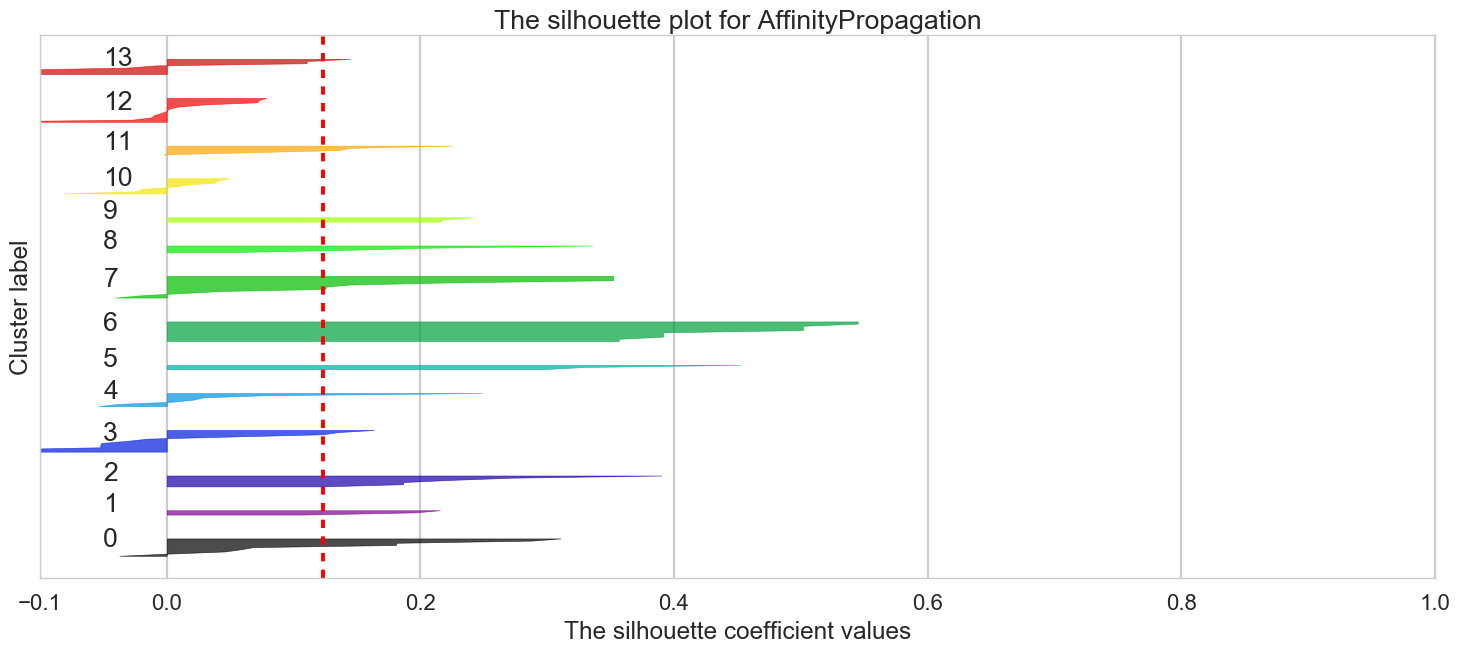

In [58]:
import matplotlib.cm as cm
graph_silhouette(afp, len(afp.cluster_centers_indices_))
None

## Results

Affinity propagation produced a silhouette score that wasn't so bad compared to KMeans clustering. The silhouettes look very good outside of three of the clusters. Overall I'm pretty impressed with affinity propagation as a method of clustering.

# Spectral Clustering

In [39]:
from sklearn.cluster import SpectralClustering

In [40]:
ns = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
avgs = []
for n in ns:
    spctrl = SpectralClustering()
    labels = spctrl.fit_predict(x_cols)
    avg = silhouette_score(x_cols, labels)
    avgs.append(avg)
    print("With {} clusters, the average silhouette score is {}".format(n, avg))

With 2 clusters, the average silhouette score is 0.0572454782216
With 3 clusters, the average silhouette score is 0.0572454782216
With 4 clusters, the average silhouette score is 0.0539150621834
With 5 clusters, the average silhouette score is 0.0201955995109
With 6 clusters, the average silhouette score is 0.0371915831706
With 7 clusters, the average silhouette score is 0.0561734344441
With 8 clusters, the average silhouette score is 0.0572454782216
With 9 clusters, the average silhouette score is 0.0448816046257
With 10 clusters, the average silhouette score is 0.0572454782216
With 11 clusters, the average silhouette score is 0.0526822430984
With 12 clusters, the average silhouette score is 0.0448816046257
With 13 clusters, the average silhouette score is 0.0572454782216
With 14 clusters, the average silhouette score is 0.0526822430984
With 15 clusters, the average silhouette score is 0.0386322743251


## Results

Spectral clustering performed very poorly on this dataset.

# Agglomerative Clustering

In [41]:
from sklearn.cluster import AgglomerativeClustering
avgs = []
for n in ns:
    agg = AgglomerativeClustering(n_clusters=n)
    labels = agg.fit_predict(x_cols)
    avg = silhouette_score(x_cols, labels)
    avgs.append(avg)
    print("With {} clusters, the average silhouette score is {}".format(n, avg))

With 2 clusters, the average silhouette score is 0.0854016288561
With 3 clusters, the average silhouette score is 0.116965699205
With 4 clusters, the average silhouette score is 0.13011921749
With 5 clusters, the average silhouette score is 0.14195353461
With 6 clusters, the average silhouette score is 0.147933025658
With 7 clusters, the average silhouette score is 0.110564298325
With 8 clusters, the average silhouette score is 0.118550842023
With 9 clusters, the average silhouette score is 0.125321340059
With 10 clusters, the average silhouette score is 0.129011904488
With 11 clusters, the average silhouette score is 0.140122099148
With 12 clusters, the average silhouette score is 0.146853820581
With 13 clusters, the average silhouette score is 0.137101468579
With 14 clusters, the average silhouette score is 0.140677285823
With 15 clusters, the average silhouette score is 0.144794411919


Average silhouette score is 0.147933025658


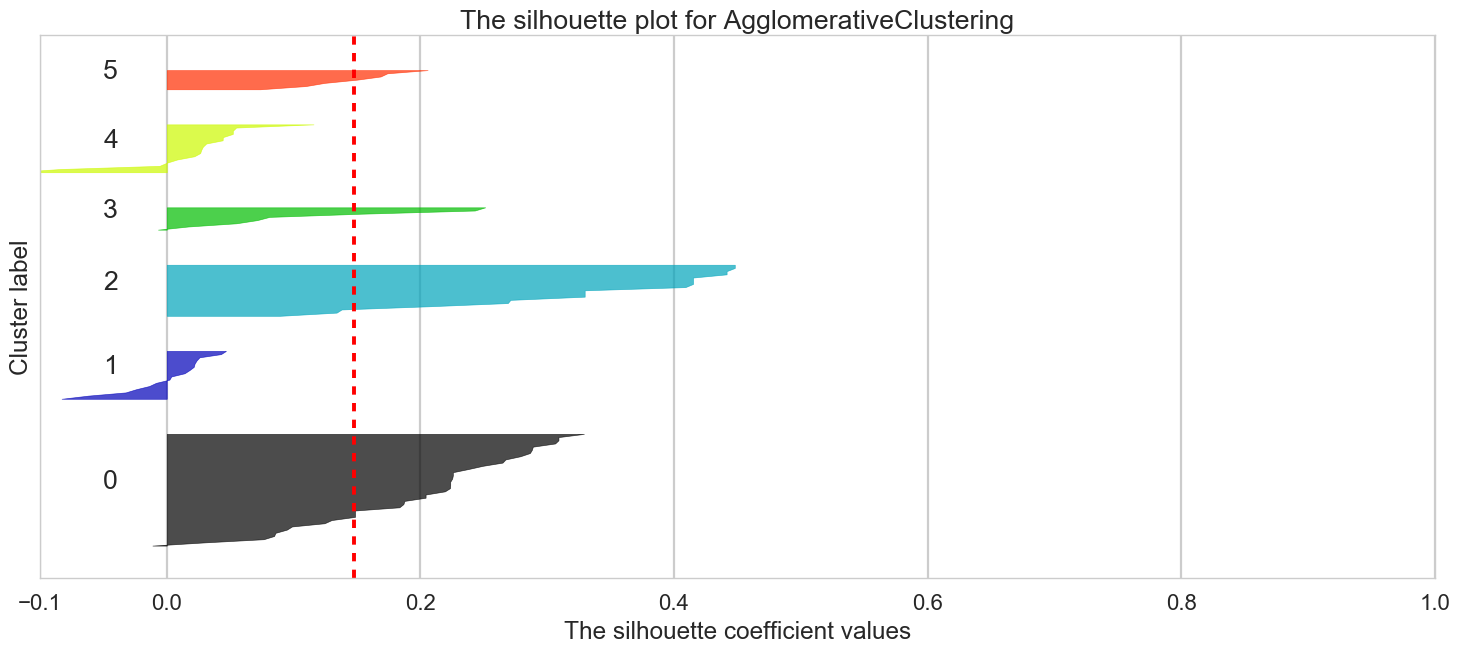

In [59]:
graph_silhouette(AgglomerativeClustering(n_clusters=6), 6)

# DBSCAN

In [87]:
from sklearn.cluster import DBSCAN

eps = [1, 1.5, 2]
min_samples = [1,2,3,4]
avgs = []
for ep in eps:
    for min_s in min_samples:
        dbs = DBSCAN(eps=ep, min_samples=min_s)
        labels = dbs.fit_predict(x_cols)
        try:
            avg = silhouette_score(x_cols, labels)
            avgs.append(avg)
            print("With {} as epsilon, and {} as min_samples, the average silhouette score is {}".format(ep, min_s, avg))
        except ValueError:
            # not enough lables for silhouette score
            print("With {} as epsilon, and {} as min_samples, not enough labels were produced".format(ep, min_s))

With 1 as epsilon, and 1 as min_samples, the average silhouette score is 0.0487022222466
With 1 as epsilon, and 2 as min_samples, the average silhouette score is 0.0254522297235
With 1 as epsilon, and 3 as min_samples, the average silhouette score is 0.0383161614218
With 1 as epsilon, and 4 as min_samples, the average silhouette score is 0.0417711827655
With 1.5 as epsilon, and 1 as min_samples, the average silhouette score is 0.0165341682405
With 1.5 as epsilon, and 2 as min_samples, the average silhouette score is 0.0950039187709
With 1.5 as epsilon, and 3 as min_samples, the average silhouette score is 0.132124010985
With 1.5 as epsilon, and 4 as min_samples, the average silhouette score is 0.121754985088
With 2 as epsilon, and 1 as min_samples, the average silhouette score is 0.164688372397
With 2 as epsilon, and 2 as min_samples, the average silhouette score is 0.234889659521
With 2 as epsilon, and 3 as min_samples, the average silhouette score is 0.234889659521
With 2 as epsilon,

Average silhouette score is 0.234889659521


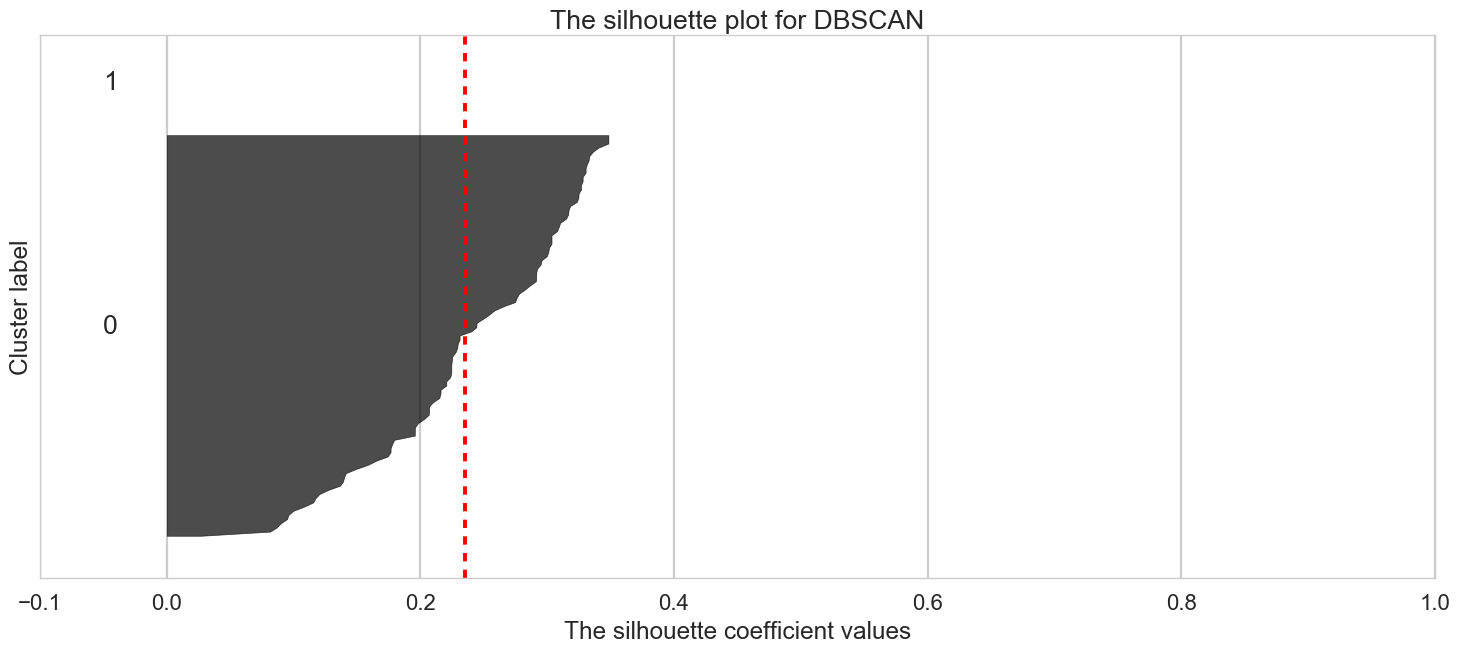

In [92]:
dbs = DBSCAN(eps=2, min_samples=2)
n_clusters = len(np.unique(dbs.fit_predict(x_cols)))
graph_silhouette(dbs, n_clusters)

# Results

DBSCAN performs optimally when it considers all points, save a few, as part of one clusters. The points left out are classified as noise.

# Story

## Not all clusters are created equal

After testing a number of different clustering methods to cluster data on successful transactions resulting from offers sent out to customers of a wine shop, I found that Agglomerative Clustering performed the best.

I used the silhouette score as my metric of comparison, but the average score did not tell the whole story. DBSCAN had the best average silhouette score, but with the hyperparameters that were determined, it classified all points as part of a single cluster, save a few points which were considered as 'noise.' 

Agglomerative Clustering found six different clusters and produced an average silhouette score of 0.148, this was better than the optimal clustering with kmeans that was found earlier.

The moral of the story here is that the average silhouette score does not tell the whole story, and that each clustering algorithm will perform a little differently, so it would be wise to test out a few on any clustering task